## Neural networks for segmentation

In [1]:
#!S:bash
#wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
#unzip -q data.zip

In [2]:
#%pip install scikit-image

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage
%matplotlib inline

In /home/dmitry/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/dmitry/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/dmitry/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/dmitry/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/dmitry/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

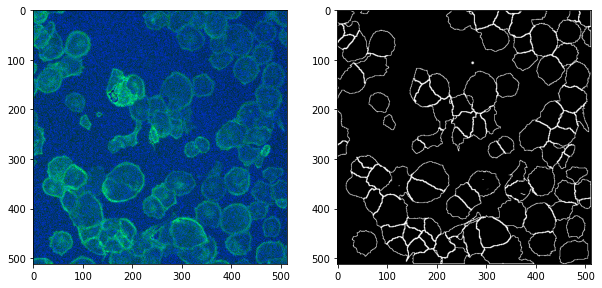

In [2]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss. You also can try to use softIoU or DICE loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [3]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [72]:
import os

path = 'BBBC018_v1_outlines/train'
result = []

for img_name in os.listdir(path):
    img = skimage.img_as_ubyte(skimage.io.imread(os.path.join(path, img_name)))
    img = target.numpy().reshape(-1)
    ones = img.sum()
    zeros = img.shape - ones
    result.append(zeros / ones)
    assert set(img) == set([0.0, 1.0])
                                                 
print('class ratio: ', np.mean(result))

class ratio:  11.607319771076805


BBBC018_v1_images-fixed/train
BBBC018_v1_outlines/train
BBBC018_v1_images-fixed/val
BBBC018_v1_outlines/val
torch.float32


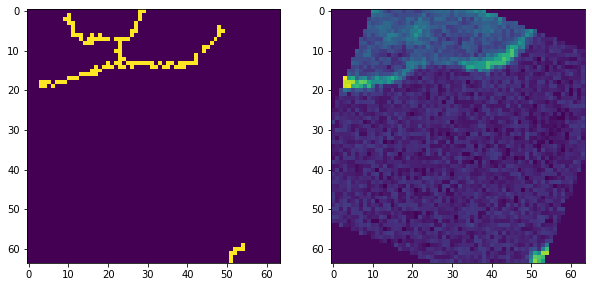

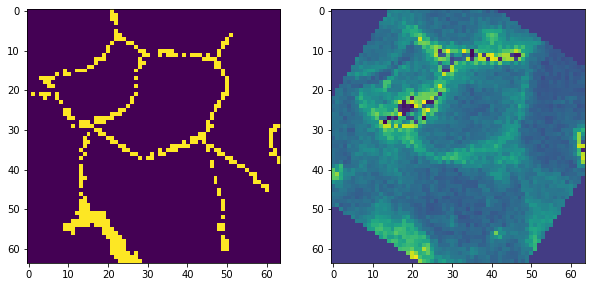

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision, torchvision.transforms as transforms
from PIL import Image
import torchvision.transforms.functional as TF
import os
from IPython import display


class CustomDataset(Dataset):
    def __init__(self, source_path, target_path, train): 
        self.source_imgs = self.load(source_path, lambda x: skimage.color.rgb2gray(x))
        self.target_imgs = self.load(target_path)
        self.img_names = list(self.source_imgs.keys())
        self.transform = self.train_transform if train else self.test_transform
        assert len(self.source_imgs) == len(self.target_imgs)

    def __getitem__(self, index):
        return self.transform(
            self.source_imgs[self.img_names[index]], self.target_imgs[self.img_names[index]]
        )

    def __len__(self):  # return count of sample we have
        return len(self.source_imgs)
    
    def load(self, path, img_transform=lambda x: x):
        print(path)
        imgs = {}
        for img_name in os.listdir(path):
            imgs[img_name.split('-')[0]] = Image.fromarray(
                img_transform(
                    skimage.img_as_ubyte(
                        skimage.io.imread(os.path.join(path, img_name)
            ))))

        return imgs
    
    def train_transform(self, image, mask):
        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(64, 64))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        
        # Random rotation
        angle = np.random.rand() * 360
        
        image = image.rotate(angle, fillcolor=0.1466)
        mask = mask.rotate(angle)

        # Random horizontal flipping
        if np.random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if np.random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        return image, mask
    
    def test_transform(self, image, mask):
        return TF.to_tensor(image), TF.to_tensor(mask)


train_loader = DataLoader(
    CustomDataset('BBBC018_v1_images-fixed/train', 'BBBC018_v1_outlines/train', True), 
    batch_size=32, shuffle=True)

val_loader = DataLoader(
    CustomDataset('BBBC018_v1_images-fixed/val', 'BBBC018_v1_outlines/val', False), 
    batch_size=1, shuffle=True)

#train_dataset = torchvision.datasets.ImageFolder('BBBC018_v1_images-fixed', transform=transform_train)
#val_dataset = torchvision.datasets.ImageFolder('BBBC018_v1_images-fixed/val', transform=transform_train)
#test_dataset = torchvision.datasets.ImageFolder('BBBC018_v1_images-fixed/test', transform=transform_train)


import time
for source, target in train_loader:
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,2)
    # print(source.shape)
    # print(source.reshape(-1).mean(axis=0))
    plt.imshow(source[0][0])

    plt.subplot(1,2,1)
    plt.imshow(target[0][0])
    #display.clear_output(wait=True)

print(source.dtype)



In [30]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [31]:
""" Full assembly of the parts to form the complete network """

# UNET from https://github.com/milesial/Pytorch-UNet/

import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

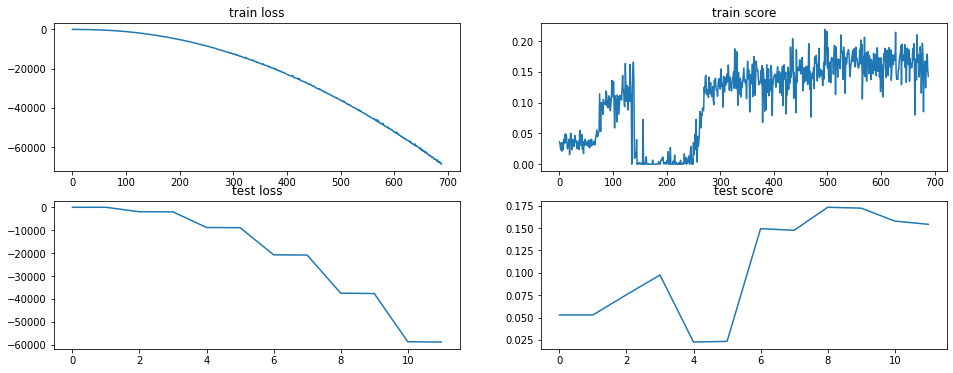

In [ ]:
from torch.optim import Adam
from tqdm import trange

model = UNet(1, 1).cuda()
model = model.train()
opt = Adam(model.parameters(), lr=1e-2)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(11.6))

train_score = []
train_loss = []
test_score = []
test_loss = []

for epoch in trange(1000):
    for source, target in train_loader:
        logits = model(source.cuda())
        loss = loss_fn(target.cuda(), logits)
        loss.backward()
        opt.step()
        opt.zero_grad()
        score = calc_iou(F.sigmoid(logits.detach().cpu()).numpy(), target.detach().numpy())
        train_loss.append(loss.detach().cpu().numpy())
        train_score.append(score)
        
        if epoch % 64 == 0:
            curr_test_loss = []
            curr_test_score = []
            with torch.no_grad():
                for testsource, testtarget in val_loader:
                    logits = model(testsource.cuda())
                    loss = loss_fn(testtarget.cuda(), logits)
                    curr_test_loss.append(loss.detach().cpu().numpy())
                    score = calc_iou(F.sigmoid(logits.cpu()).numpy(), testtarget.numpy())
                    curr_test_score.append(score)
            test_loss.append(np.mean(curr_test_loss))
            test_score.append(np.mean(curr_test_score))
        
        display.clear_output(wait=True)
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 6))
        ax1.plot(train_loss)
        ax1.set_title('train loss')
        
        ax2.plot(train_score)
        ax2.set_title('train score')
        
        ax3.plot(test_loss)
        ax3.set_title('test loss')
        
        ax4.plot(test_score)
        ax4.set_title('test score')
        plt.show()
        
        
    


NameError: name 'hui' is not defined

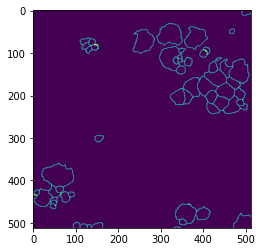

In [87]:
model = model.eval()

for source, target in val_loader:
    with torch.no_grad():
        logits = model(source.cuda())
        pred = F.sigmoid(logits).cpu().numpy()
        plt.imshow(pred[0][0])
        plt.imshow(target[0][0])
        hui
        

In [14]:
def dice_loss(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti